# TA Review 3
*3/4/2025*

## FINM 37500 - 2025

### UChicago Financial Mathematics

* Burak Sekerci
* bsekerci@uchicago.edu

### Agenda

- SABR
- Treasury Futures
 <br>

### SABR Review via Homework 2 Solutions ###

### What is SABR?

It is a way to model volatility. It fits volatility in a stochastic framework while using real World data. We have two processes:

![Screenshot 2025-02-23 at 12.17.18 PM.png](<attachment:Screenshot 2025-02-23 at 12.17.18 PM.png>)
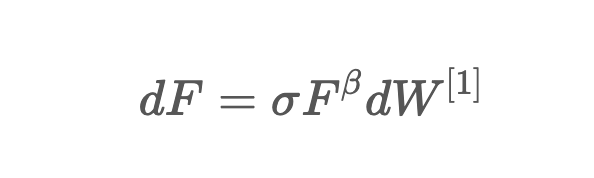

![Screenshot 2025-02-23 at 12.17.35 PM.png](<attachment:Screenshot 2025-02-23 at 12.17.35 PM.png>)
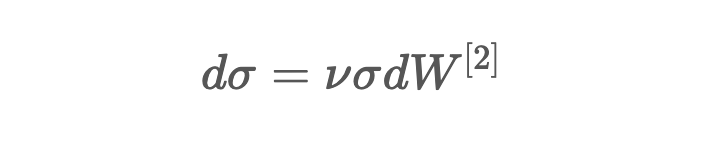

We have the forward process and the volatility process. We also have multiple parameters we need to optimize/set:

- Beta: Set according to what you are trying to model. Usually using 0.5 or 0.75 for interest rate derivatives. 
- alpha: Sigma 0, you can simplify the problem of SABR by using the approximation for ATM options and only optimize for two parameters. 
- Rho: The correlation between the two Brownian motions shown above. Needs to be optimized. 
- Nu: Vol of vol. Needs to be optimized. 

### Homework 2 solutions ###

In [11]:
import numpy as np
import pandas as pd

from datetime import date
from datetime import datetime

import sys
sys.path.insert(0, '../cmds')
from ficcvol import *
from ratecurves import *
from treasury_cmds import compound_rate
from volskew import *

import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

import matplotlib.ticker as mtick
from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

In [ ]:
# Define the valuation date and frequency of the interest rate curve
DATE = '2025-01-31'  # Valuation date for the swaption pricing
freqcurve = 4  # Frequency of the interest rate curve (quarterly compounding)

# Define swaption characteristics
SWAP_TYPE = 'SOFR'  # Type of swap (SOFR-based fixed-for-floating swap)
QUOTE_STYLE = 'black'  # Quoting style (Black’s model for implied volatilities)
RELATIVE_STRIKE = 0  # ATM strike relative to forward swap rate

expry = 1  # Swaption expiration in years (1 year)
tenor = 4  # Underlying swap tenor in years (4 years)

freqswap = 4  # Payment frequency of the underlying swap (quarterly)
isPayer = True  # Defines whether it's a payer or receiver swaption
N = 100  # Notional value of the swaption (used in pricing calculations)

# Load interest rate curve data
curves = pd.read_excel(f'../data/cap_curves_{DATE}.xlsx', 
                       sheet_name=f'rate curves {DATE}').set_index('tenor')

# Define the expiration and maturity of the swaption
Topt = expry  # Swaption expiration (T = 1 year)
Tswap = Topt + tenor  # Swap maturity (T + 4 years = 5 years)

# Extract forward interest rate for the expiration time
fwdrate = curves['forwards'][Topt]  # Forward rate at the expiration of the swaption

# Compute the forward swap rate for the 1y4y swaption
fwdswap = calc_fwdswaprate(curves['discounts'], Topt, Tswap, freqswap=freqswap)

# Load implied volatility data for swaptions
voldata = pd.read_excel(f'../data/swaption_vol_data_{DATE}.xlsx')  # Load market swaption volatilities

# Filter volatilities for the chosen swaption type, model, and date
volquote = voldata.query(f'model=="{QUOTE_STYLE}"') \
                  .query(f'reference=="{SWAP_TYPE}"') \
                  .query(f'date=="{DATE}"')

# Identify the specific swaption with 1-year expiration and 4-year tenor
idx = (volquote['expiration'] == expry) & (volquote['tenor'] == tenor)
volquote = volquote.loc[idx]  # Extract relevant row(s)
volquote.index = ['implied vol']  # Rename index for clarity

# Extract strike prices and implied volatilities
strikerange = np.array(volquote.columns[-9:].tolist())  # Retrieve the range of strikes from the last 9 columns
vols = volquote[strikerange]  # Store implied volatilities for corresponding strikes
vols /= 100  # Convert volatilities from percentage format to decimal

# Convert relative strike range into absolute strike prices
strikes = fwdswap + strikerange / 100 / 100 ###strike range is relative this becomes absolute

# Identify the index of the ATM strike
idstrike = np.where(strikerange == RELATIVE_STRIKE)[0][0]  # Find the position of the ATM strike
idstrikeATM = np.where(strikerange == 0)[0][0]  # Identify index where relative strike is exactly 0% (ATM)

# Adjust volatilities if the quote style is "normal" instead of Black's model
if QUOTE_STYLE == 'normal':
    vols /= 100 * fwdrate  # Convert normal vol to Black vol by scaling with the forward rate

# Extract the ATM cap volatility from the interest rate curve data
capvol = curves.loc[Topt, 'fwd vols']  # Forward volatility for the cap at the swaption expiration

# Extract the ATM strike and corresponding implied volatility
strikeATM = strikes[idstrikeATM]  # Retrieve the absolute ATM strike price
volATM = vols.iloc[0, idstrikeATM]  # Retrieve the ATM implied volatility

# Find the index location of the forward rate for the swaption expiration (Topt)
period_fwd = curves.index.get_loc(Topt)  

# Find the index location of the forward rate for the swap maturity (Tswap)
period_swap = curves.index.get_loc(Tswap) + 1  
# - `Tswap` is the maturity of the underlying swap (Topt + tenor, e.g., 5 years)
# - `+1` ensures that we include the swap maturity point

# Determine the step size for extracting relevant discount factors
step = round(freqcurve / freqswap)  
# - `freqcurve` represents how often the curve is quoted (e.g., quarterly = 4)
# - `freqswap` represents the frequency of payments on the swap (e.g., quarterly = 4)
# - The step size ensures we select only relevant discount factors for cash flow periods

# Compute the sum of discount factors relevant to the swap cash flows
discount = curves['discounts'].iloc[period_fwd + step : period_swap : step].sum() / freqswap  
# - Extracts the discount factors for each **swap payment period**:
#   - Starts from `period_fwd + step` (first cash flow after swaption expiry)
#   - Stops at `period_swap` (swap maturity)
#   - Steps by `step` (quarterly intervals)
# - Sums up the discount factors to get the **present value of swap cash flows**.
# - Divides by `freqswap` to account for **payment frequency normalization**.


In [19]:
def obj_fun(xargs):
    nu = xargs[0]
    rho = xargs[1]
    alpha = xargs[2]
    
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr(BETA,nu,rho,alpha,F,strike,Topt)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error


def obj_fun_slim(xargs):
    nu = xargs[0]
    rho = xargs[1]
    ivolSABR = np.zeros(len(strikes))
    
    for i,strike in enumerate(strikes):
         ivolSABR[i] = sabr_slim(BETA,nu,rho,F,strike,Topt,volATM)
    
    error = ((ivolSABR - vols.values)**2).sum()
    
    return error

In [20]:
doSLIM = False
BETA = 0.75
F = fwdswap-1e-8 ### Adjust the Forward swap rate for numerical stability

In [21]:
if not doSLIM:
    x0 = np.array([.6,0,.1])
    fun = obj_fun
else:
    fun = obj_fun_slim
    x0 = np.array([.6,0,.1])

optim = minimize(fun,x0)
xstar = optim.x
nustar = xstar[0]
rhostar = xstar[1]
   
if doSLIM:
    alphastar = solve_alpha(BETA,nustar,rhostar,Topt,volATM,F)
    ivolSABR = sabr_slim(BETA,nustar,rhostar,F,strikes,Topt,volATM)
else:
    alphastar = xstar[2]
    ivolSABR = sabr(BETA,nustar,rhostar,alphastar,F,strikes,Topt)
    
error = optim.fun

## 2.1 - Compute SABR Full

We did our optimization for the full SABR model. 

In [22]:
param = pd.DataFrame([BETA,alphastar,nustar,rhostar,error],index=['beta ($\\beta$)','alpha ($\\alpha$)','nu ($\\nu$)','rho ($\\rho$)','fit error'],columns=['SABR Parameters']).style.format('{:.4f}')
param

,SABR Parameters
beta ($\beta$),0.7500
alpha ($\alpha$),0.1128
nu ($\nu$),0.6914
rho ($\rho$),-0.3447
fit error,0.0000


## 2.2 - Plot the SABR grid

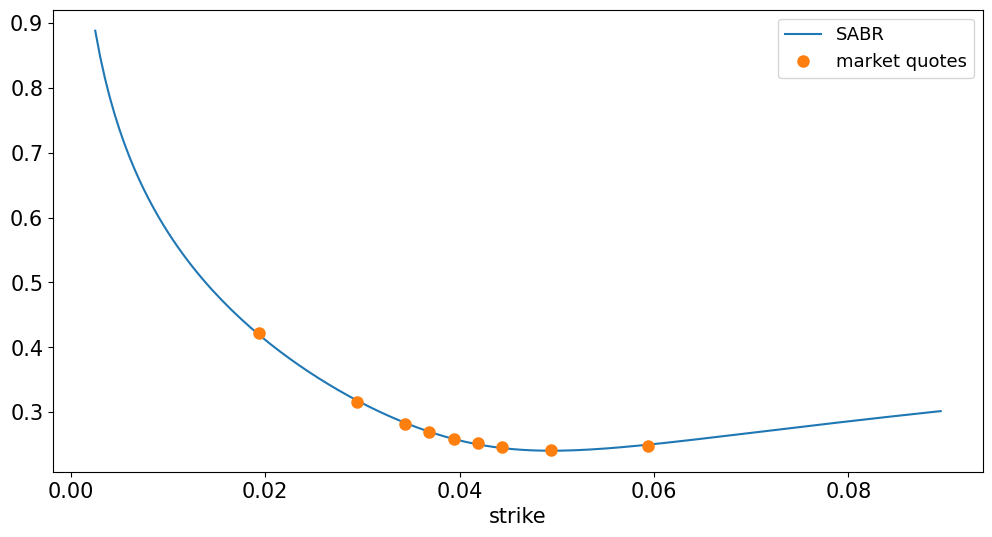

In [29]:
# Define a grid of strikes for plotting the SABR volatility curve
strikegrid = np.arange(.0025, .09, .0005)  # Creates a strike range from 0.25% to 9% with 5bps increments

# Compute the SABR-implied volatilities for the strike grid
if doSLIM:
    ivolgrid = sabr_slim(BETA, nustar, rhostar, F, strikegrid, Topt, volATM)  
    # If using the alternative method (SLIM), compute volatilities without α optimization
else:
    ivolgrid = sabr(BETA, nustar, rhostar, alphastar, F, strikegrid, Topt)  
    # Otherwise, use the full SABR model with α estimated via optimization

# Store the computed SABR volatility curve in a DataFrame
sabrcurve = pd.DataFrame(ivolgrid, index=strikegrid, columns=['SABR'])  
# This table will be used for plotting the fitted SABR volatility curve

# Make a copy of the market-implied volatility quotes
volquotes = vols.copy()

# Add a row for the absolute strike prices
volquotes.loc['strike'] = strikes  # Append strike prices as a new row

# Transpose and reformat the volatility quotes for plotting
volquotes = volquotes.T.set_index('strike').rename(columns={'implied vol': 'market quotes'})
# - Transpose (`T`) so that strikes become index values
# - Set index to strikes so we can compare market vs model volatilities
# - Rename the 'implied vol' column to 'market quotes' for clarity

# Plot the SABR volatility curve and market quotes
fig, ax = plt.subplots()  # Create a figure and axis for plotting

sabrcurve.plot(ax=ax)  # Plot the SABR-implied volatility curve
volquotes.plot(linestyle='', marker='o', markersize=8, ax=ax)  
# - Market quotes are plotted as discrete points ('o' markers)
# - No connecting lines (`linestyle=''`)
# - Larger marker size (`markersize=8`) to distinguish market data points

plt.legend();  # Display a legend showing the different curves

## 2.3 - Recalculate 1y4y swaption with a deep out of the money strike of 5%

In [ ]:
NEWSTRIKE = .05

## Recalculate the volatility and price of the OTM swaption at a new strike of 5%

if doSLIM:
    newvol = sabr_slim(BETA,nustar,rhostar,F,NEWSTRIKE,Topt,volATM)
else:
    newvol = sabr(BETA,nustar,rhostar,alphastar,F,NEWSTRIKE,Topt)

newprice = N * blacks_formula(Topt,newvol,NEWSTRIKE,fwdswap,discount,isCall=isPayer)
display(f'Price of the OTM swaption at strike {NEWSTRIKE:.2%} is ${newprice:.4f}.')

'Price of the OTM swaption at strike 5.00% is $0.3179.'

## Problem 3 - Shift the Forward by 50 bps

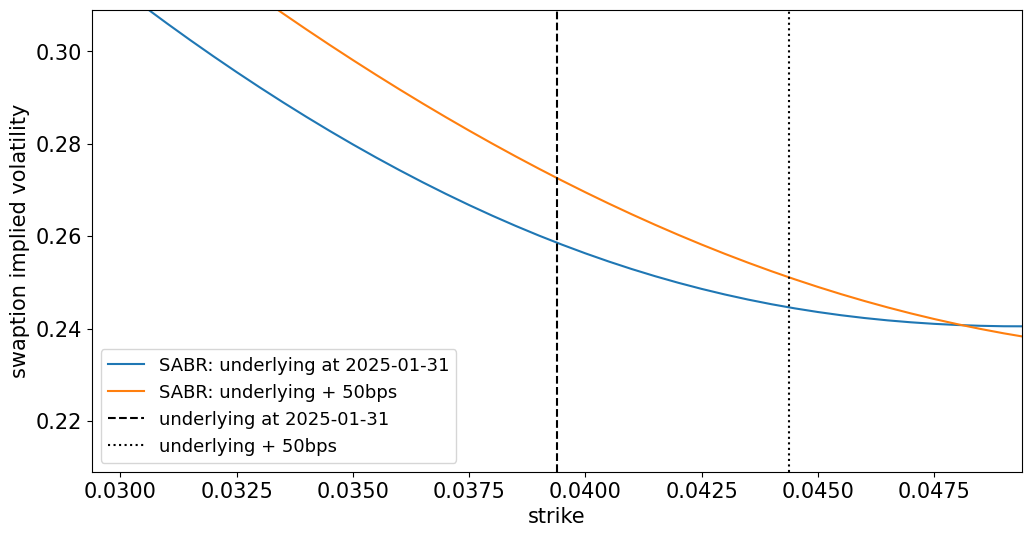

In [35]:
# Suppress warnings to avoid unnecessary output
warnings.filterwarnings('ignore')

# Define a shift of +50 basis points (bps) = 0.50% = 0.0050 in decimal
SHIFT = +50 / 100 / 100  

# Rename the original SABR volatility curve column for clarity
sabrcurve.rename(columns={'SABR': f'SABR: underlying at {DATE}'}, inplace=True)

# Compute the new SABR-implied volatility curve after shifting the forward rate up by 50bps
if doSLIM:
    sabrcurve[f'SABR: underlying + {SHIFT * 100 * 100:.0f}bps'] = sabr_slim(BETA, nustar, rhostar, F + SHIFT, strikegrid, Topt, volATM)
else:
    sabrcurve[f'SABR: underlying + {SHIFT * 100 * 100:.0f}bps'] = sabr(BETA, nustar, rhostar, alphastar, F + SHIFT, strikegrid, Topt)

# Plot the original and shifted SABR volatility curves
fig, ax = plt.subplots()
sabrcurve.plot(ax=ax)

# Adjust the plot window to focus on the ATM region
plt.xlim([F - 0.01, F + 0.01])  
plt.ylim([volATM - 0.05, volATM + 0.05])

# Add vertical lines to indicate the original and shifted forward rates
plt.axvline(F, color='k', linestyle='--', label=f'underlying at {DATE}')
plt.axvline(F + SHIFT, color='k', linestyle=':', label=f'underlying + {SHIFT * 100 * 100:.0f}bps')

# Label the plot and display the legend
plt.ylabel('swaption implied volatility')
plt.xlabel('strike')
plt.legend()

## 3.2 - 

In [42]:
# Find the closest strike to the ATM forward swap rate
idloc = (sabrcurve.index.to_series() - fwdswap).abs().idxmin()

# Extract the SABR-implied volatilities for the ATM strike before and after the shift
newvols = sabrcurve.loc[idloc]
strikeATM = strikes[idstrikeATM]

# Define the range of forward swap rates before and after the shift
Frange = F + [0, SHIFT]

# Find the period indices for swaption expiration and swap maturity
period_fwd = curves.index.get_loc(Topt)
period_swap = curves.index.get_loc(Tswap) + 1
step = round(freqcurve / freqswap)  # Compute step size for quarterly payments

# Compute the discount factor by summing up discount factors relevant to the swap cash flows
discount = curves['discounts'].iloc[period_fwd + step : period_swap : step].sum() / freqswap

# Compute swaption prices using Black's formula before and after the rate shift
blackprices = pd.Series(
    N * blacks_formula(Topt, newvols[0], NEWSTRIKE, Frange, discount, isCall=isPayer), 
    index=['no change in rates', 'shift in rates'], 
    name='no change in vol'
).to_frame().T
## This function has the no change in vol (newvols[0] is the old vol without the shift)

# Compute swaption price after both the rate shift and volatility shift (dynamic vol pricing)
blackprices.loc['dynamic vol', 'shift in rates'] = N * blacks_formula(
    Topt, newvols[1], NEWSTRIKE, Frange[1], discount, isCall=isPayer
)
## This function has the change in vol (newvols[1] is the new vol with the shift)


# Format and display results
blackprices.style.format('{:.2f}')

,no change in rates,shift in rates
no change in vol,0.39,0.90
dynamic vol,nan,0.98


In [40]:
dprices = (blackprices[['shift in rates']] - blackprices.loc['no change in vol', 'no change in rates'])  
# - `blackprices[['shift in rates']]` selects the column that contains swaption prices **after the rate shift**.
# - `blackprices.loc['no change in vol', 'no change in rates']` selects the **original swaption price** (before rate and volatility shift).
# - The difference gives the **absolute price change** due to the shift.

# Rename the column for clarity
dprices = dprices.rename(columns={'shift in rates': 'price change'})  
# - Renames "shift in rates" to "price change" to clearly indicate what the column represents.

# Compute the delta (sensitivity of swaption price to a 50bps change in the underlying forward rate)
delta = dprices / SHIFT  
# - `dprices` gives the absolute price change.
# - `SHIFT` is **0.0050 (50bps in decimal)**.
# - Dividing by `SHIFT` gives **delta**, which measures the price change per unit of forward rate change.

# Format the delta values for better readability
delta.style.format('{:.2f}')  
# - Formats the numbers to **two decimal places** for clear output.
# - `style.format('{:.2f}')` ensures the delta is displayed in a human-readable format.


,price change
no change in vol,102.52
dynamic vol,119.04


In [39]:

delta_relative_change = delta.pct_change().loc['dynamic vol','price change']
display(f'Relative change to delta: {delta_relative_change : .2%}.')

'Relative change to delta:  16.11%.'

## Treasury Futures ##

#### Start with Forwards ####

In order to understand treasury futures we need to understand forwards first. 

Forwards:
-	A forward contract is a commitment at time  t  to purchase an asset at future time  T  for a price  $\mathcal{F}_{t,T}$ .
-	The contract is structured so that its initial value is zero when entered.
-	Unlike options, the final value at expiration may be positive or negative for either party.
-	Forwards are similar in nature to swaps and futures, though they differ in settlement and standardization

You can think of a forward this way: I bought a bond, repo'd it at the repo rate and then bought it back at some future time. The person who bought it from me enjoyed the coupon of the bond and I enjoyed the repo rate. Now if the coupon rate of the bond is higher than the repo rate itself, the fair forward price of the bond is lower because I lost out on potential income that I could earn by holding the bond itself.

Carry is essentially the difference between the coupon rate and repo rate. If coupon > repo; forward price is lower and vice versa. Usually this is the case hence we call this effect the forward drop. 

#### On to the Futures ####

# Differences Between Forwards and Treasury Futures

## Similarities
Both **forwards** and **futures** serve similar purposes in pricing, hedging, and speculation, but they have key structural differences.

## Key Differences
| Feature | **Forwards** | **Treasury Futures** |
|---------|------------|----------------|
| **Trading Venue** | Over-the-counter (OTC) | Exchange-traded (CBOT) |
| **Standardization** | Customized terms | Standardized contracts |
| **Credit Risk** | Counterparty risk | Exchange eliminates counterparty risk |
| **Margin Requirement** | Usually none | Requires margin |
| **Settlement** | Settles at expiration | Daily mark-to-market (MTM) settlement |
| **Price Behavior** | Theoretical pricing model | Affected by MTM settlement and optionality |

## Consequences of These Differences
1. **Credit Risk:** Futures are centrally cleared, while forwards have counterparty risk.
2. **Daily Settlement Affects Pricing:** Futures undergo daily MTM, leading to cash flow differences.
3. **Cheapest-to-Deliver (CTD) Option:** Treasury futures allow for a range of deliverable bonds, influencing pricing.


# Daily Settlement and Pricing

## What is Daily Settlement?
- Treasury futures undergo **daily mark-to-market (MTM) settlement**, meaning P&L is realized **daily** rather than at expiration.
- This affects pricing because:
  - Losses must be **paid immediately** (requires financing).
  - Gains cannot be reinvested at the original rate.
  - Due to this issue futures prices are lower than the forward prices because cashflows are asymmteric. 
    * When bond price is up, rates down, which means opportunity to invest the profit is not great. 
    * When bond price is down, rates are up, and losses are financed at this high rate. 

# Tailing the Hedge

## Concept
- Since futures contracts have **daily settlement**, they react more sensitively to price movements than forwards.
- A futures hedge requires **fewer contracts** than a forward hedge.

## Formula
The number of futures contracts required is adjusted by a discount factor:
$[ N_t^{\text{fut}} = Z(t,T)N_t^{\text{fwd}}]$
where $(Z(t,T))$ is the discount factor:
$[ Z(t,T) = \frac{1}{1 + r^{\text{repo}}(t,T) \times \text{Years}_{ACT/360}}]$

## Bond Futures ##
Bond futures are exchange-traded contracts obligating the buyer to take delivery of a Treasury bond at a specified future date and price.

## Most-Traded Treasury Futures Contract
- **10-Year U.S. Treasury Note Future (TY)**
- Other contracts include:
  - 2-Year, 5-Year, and 30-Year Treasury futures
  - Ultra Treasury futures for longer maturities

## Key Features
- Standardized contract sizes and expiration dates
- Centralized clearing reduces counterparty risk
- Subject to **daily mark-to-market (MTM) settlement**

---

# Delivery, Pricing, and CTD

## Delivery Options
- Treasury futures allow for delivery of a range of Treasury bonds rather than a specific issue.
- Example for 10-Year Treasury Futures:
  - Any Treasury note with **6.5 to 10 years** remaining to maturity is eligible.
  - Prevents market squeezes and ensures liquidity.

## Conversion Factors
- Not all deliverable bonds are equal; CBOT assigns **conversion factors** to adjust for differences in maturity and coupon.
- Futures delivery price is adjusted by the bond's conversion factor:

  $[
  \text{Invoice Price} = F_T \times \psi^i
  ]$

  where:
  * $(F_T)$ is the futures settlement price.
  * $(\psi^i)$ is the conversion factor of bond $( i )$.

## Cheapest-to-Deliver (CTD)
- The CTD bond is the one with the **lowest delivery cost** for the short futures position.
- As expiry gets closer, the cost to deliver each bond changes by the formula $P_i - F_T * \psi^i$
- CTD price satisfies:

  $[
  P_T^{\text{CTD}} = \psi^{\text{CTD}} \times F_T
  ]$

- This bond heavily influences the pricing of the futures contract.

---
Since Conversion Factors are built on 6% constant yield assumption:

- 	Low-coupon bonds tend to be CTD in low-rate environments (below 6%).
-   If the yield curve is flat than it should be that all maturities are attractive to deliver.  
- 	A steepening curve shifts CTD to longer bonds, while a flattening curve shifts CTD to shorter bonds due to duration affects. |

---

# Optionality in Treasury Futures

## Embedded Options for the Short Position
- **EOM Option**: The short can choose any eligible bond for delivery even after the future contract has ceded trading. Since the future price is locked, and the spot prices keep moving, possible that a different bond becomes CTD than the bond which set the futures price at last trade date.
- **Timing Option**: The short can deliver at any time during the delivery month. Result: If coupon rate > repo rate; wait until the very end to deliver to collect carry and retain option value. 
- **Wildcard Option**: The short can wait to see price movements after exchange close before choosing to deliver.

## Impact on Pricing
- These options **benefit the short**, making futures trade at a discount to theoretical forward prices.
- CTD bond determination is dynamic, adjusting to rate movements.



---


# Basis Trading Overview

## Definition
Basis trading involves arbitraging the difference between the price of a Treasury bond and the futures contract in which it can be delivered.

## Mechanics of a Basis Trade
- **Long the bond** in the spot market.
- **Short the corresponding Treasury futures contract**.
- Adjust for the **conversion factor** to account for the difference in bond characteristics.

## Key Trading Measures
- **Gross Basis**: The price difference between the bond and its adjusted futures price.
- **Net Basis**: The forward price difference after accounting for carry.

---

# Gross and Net Basis

## Gross Basis Formula
$[
    \text{Gross Basis} = P_t^i - \psi^i F_T
]$
where:
- $(P_t^i)$ is the **spot price** of bond $(i)$.
- $(\psi^i)$ is the **conversion factor**.
- $(F_T)$ is the **futures price**.

## Net Basis Formula
$[
    \text{Net Basis} = \text{Gross Basis} - \text{Carry}
]$
where:
- **Carry** = Coupon Income - Repo Cost.

## Convergence at Expiry
At expiration $(T):
[
    \text{Gross Basis}_T = \text{Net Basis}_T = 0
]$
This means that at expiration, the bond and futures contract prices must align exactly.

---

# The Role of Repo and Carry

## Repo in Basis Trading
- The ability to **finance the bond via repo** is crucial.
- If the repo rate is **high**, the cost of holding the bond increases, lowering net basis.
- If the repo rate is **low**, holding the bond is cheaper, increasing net basis.

## Carry in Basis Trading
$[
    \text{Carry}^i = \text{Coupon}^i - \text{Repo Rate}
]$
- **Positive Carry**: The bond’s coupon is **higher** than the repo rate.
- **Negative Carry**: The bond’s coupon is **lower** than the repo rate.

Understanding repo rates and carry dynamics is essential to structuring profitable basis trades.

In [8]:
# Sample values for a Treasury bond
spot_price = 102.50  # Spot price of the bond
futures_price = 101.75  # Futures price
conversion_factor = 0.98  # Conversion factor
repo_rate = 0.03  # 3% annualized repo rate
coupon = 0.04  # 4% annualized coupon
face_value = 100  # Standard bond face value
daysToExpiry = 180  # Days to expiry

dirty_price = spot_price  # Assuming no major accrued interest, if there is accrued interest add this

# Compute Gross Basis
gross_basis = spot_price - (conversion_factor * futures_price)

# Compute Coupon Income
coupon_income = (face_value * coupon)

# Compute Repo Cost
repo_cost = dirty_price * repo_rate

# Compute Carry
carry = (coupon_income - repo_cost) * daysToExpiry / 360 # Scale because we are using annualized rates

# Compute Net Basis
net_basis = gross_basis - carry

print(f"Gross Basis: {gross_basis:.4f}")
print(f"Coupon Income: {coupon_income:.4f}")
print(f"Repo Cost: {repo_cost:.4f}")
print(f"Carry: {carry:.4f}")
print(f"Net Basis: {net_basis:.4f}")

Gross Basis: 2.7850
Coupon Income: 4.0000
Repo Cost: 3.0750
Carry: 0.4625
Net Basis: 2.3225
